# HSE 2021: Mathematical Methods for Data Analysis

## Homework 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import datasets
from sklearn.datasets import load_boston

%matplotlib inline

sns.set(style="darkgrid")

### Data

For this homework we use Boston Dataset from sklearn (based on UCI ML housing dataset).

In [3]:
data = load_boston() # load dataset

X = data.data
y = data.target
columns = data.feature_names

## Linear regression

#### 1. [0.5 points] Create Pandas DataFrame and split the data into train and test sets with ratio 80:20 with random_state=0.

In [4]:
from sklearn.model_selection import train_test_split

df = pd.DataFrame(X, columns = columns)
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2, random_state = 0)

#### 2. [1 point] Train models on train data using StatsModels library and apply it to the test set; use $RMSE$ and $R^2$ as the quality measure.

* [`LinearRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html);
* [`Ridge`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) with $\alpha = 0.01$;
* [`Lasso`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) with $\alpha = 0.01$

Don't forget to scale the data before training the models with StandardScaler!

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)
model = sm.OLS(y_train, X_train_scaled)
results = model.fit()
y_pred = results.predict(X_test_scaled)

print("Linear Regression RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
print("Linear Regression R2_Score ", r2_score(y_test, y_pred))

Ridge = sm.OLS(y_train, X_train_scaled)
rmodel =Ridge.fit_regularized(alpha=0.01, L1_wt=0)
ry_pred = rmodel.predict(X_test_scaled)
print("Ridge RMSE: ", mean_squared_error(y_test, ry_pred, squared=False))
print("Ridge R2_Score ", r2_score(y_test, ry_pred))

Lasso = sm.OLS(y_train, X_train_scaled)
lmodel =Lasso.fit_regularized(alpha=0.01, L1_wt=1)
ly_pred = lmodel.predict(X_test_scaled)
print("Lasso RMSE: ", mean_squared_error(y_test, ly_pred, squared=False))
print("Lasso R2_Score ", r2_score(y_test, ly_pred))

Linear Regression RMSE:  5.783509315085139
Linear Regression R2_Score  0.5892223849182503
Ridge RMSE:  5.8270281466103295
Ridge R2_Score  0.5830172183998507
Lasso RMSE:  5.796213850902314
Lasso R2_Score  0.5874157064480486


#### 3. [1 point] Explore the values of the parameters of the resulting models and compare the number of zero weights in them. Comment on the significance of the coefficients, overal model significance and other related factors from the results table

In [6]:
print(results.params)
print(rmodel.params)
print(lmodel.params)
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

[22.61188119 -0.97082019  1.05714873  0.03831099  0.59450642 -1.8551476
  2.57321942 -0.08761547 -2.88094259  2.11224542 -1.87533131 -2.29276735
  0.71817947 -3.59245482]
[22.38800118 -0.9389153   0.9964658  -0.05759679  0.60978151 -1.72221088
  2.61200412 -0.11553458 -2.75390827  1.83481449 -1.6264754  -2.25612295
  0.71882981 -3.52865629]
[22.60188119 -0.94032071  1.02149689  0.          0.59478962 -1.80291733
  2.58516537 -0.06898551 -2.80847418  1.95673449 -1.73917996 -2.27880622
  0.70557048 -3.59691505]


It seems to me that all of these three models have approximately the same parameters. Only x3 in Lasso is truly zero.
The closest values to 0 are x3, x7. This may be due to the fact that either these are insignificant parameters, or the values in these parameters are so large and have a large scatter. But the second option in our case is impossible, since we normalize our data before training, which is just struggling with such cases.

Как мне кажется, все из этих трех моделей имеют примерно одинаковые параметры. Истинно нулевое значение имеет только x3 в Lasso.
Самые близкие к 0 значения - это x3, x7. Это может быть связано с тем, что либо это незначимые параметры, либо значения в этих параметрах настолько большие и имеют большой разброс. Но второй вариант в нашем случае невозможен, так как мы перед обучением нормируем наши данные, что как раз борется с такими случаями.

#### 4. [1 point] Implement one of the elimination algorithms that were described in the Seminar_4 (Elimination by P-value, Forward elimination, Backward elimination), make conclusions.

In [7]:
def train(df, y):
    X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2, random_state = 0)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = sm.add_constant(X_train_scaled)
    X_test_scaled = sm.add_constant(X_test_scaled)
    model = sm.OLS(y_train, X_train_scaled)
    results = model.fit()
    return results, mean_squared_error(y_test, results.predict(X_test_scaled), squared=False)

def find_best_pvalue(df, y):
    dfnew = df
    
    results, rmse = train(dfnew, y)
    new_rmse = rmse
    new_results = results
    while(new_rmse <= rmse):
        rmse = new_rmse
        results = new_results
        max_p_value_index = 0
        for i in range(len(results.pvalues)):
            if results.pvalues[i] == results.pvalues.max():
                max_p_value_index = i - 1
                break
        dfnew = dfnew.drop(dfnew.columns[max_p_value_index], axis=1)
        new_results, new_rmse = train(dfnew, y)
    return results

print(find_best_pvalue(df, y).summary2())


                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.765    
Dependent Variable: y                AIC:                2370.9385
Date:               2021-03-13 15:48 BIC:                2426.9583
No. Observations:   404              Log-Likelihood:     -1171.5  
Df Model:           13               F-statistic:        102.2    
Df Residuals:       390              Prob (F-statistic): 9.64e-117
R-squared:          0.773            Scale:              20.020   
--------------------------------------------------------------------
           Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
--------------------------------------------------------------------
const     22.6119     0.2226   101.5764   0.0000   22.1742   23.0495
x1        -0.9708     0.2980    -3.2575   0.0012   -1.5568   -0.3849
x2         1.0571     0.3408     3.1022   0.0021    0.3872    1.7271
x3         0.0383     0.4428     0.0865   0.9311   -0.8324    0.9090

As we can see, we didn’t have to delete any elements in order to get the model better in terms of metrics. This does not necessarily mean that all elements are significant. Here in the task it says, as far as I understand, that we stop after the first degradation of rmse. But the first deterioration occurs when we remove the very first feature (by p-value). But if we remove the second feature, then our model will still improve, and further removal of features will worsen the model.

Как мы видим, нам не пришлось удалять какие-то элементы для того, чтобы модель получалась по метрикам лучше. Это не совсем означает, что все элементы значимы. Тут в задании сказано, насколько я понял, чтобы мы остановились после первого ухудшения rmse. Но первое ухудшение наступает, когда мы удаляем первый самый признак (по p-value). Но если мы удалим и второй признак, то тогда наша модель всё-таки улучшится, а дальнейшие удаления признаков будут ухудшать модель. 

#### 5. [1 point] Find the best (in terms of RMSE) $\alpha$ for Ridge regression using cross-validation with 5 folds. You must select values from range $[10^{-4}, 10^{3}]$.

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = 0.2, random_state = 0)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

parameters = {'alpha':np.logspace(-4, 3,100)}
ridge = Ridge()
clf = GridSearchCV(ridge, parameters,scoring='neg_root_mean_squared_error')
clf.fit(X_train_scaled, y_train)
clf.best_params_

{'alpha': 7.56463327554629}

## Gradient descent

#### 6. [3.5 points] Implement a linear regression model for the MSE loss function, trained by gradient descent.

All calculations must be vectorized, and python loops can only be used for gradient descent iterations. As a stop criterion, you must use (simultaneously):

* checking for the Euclidean norm of the weight difference on two adjacent iterations (for example, less than some small number of the order of $10^{-6}$, set by the `tolerance` parameter);
* reaching the maximum number of iterations (for example, 10000, set by the `max_iter` parameter).

You need to implement:

* Full gradient descent:

$$
w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} Q(w_{k}).
$$

* Stochastic Gradient Descent:

$$
w_{k + 1} = w_{k} - \eta_{k} \nabla_{w} q_{i_{k}}(w_{k}).
$$

$\nabla_{w} q_{i_{k}}(w_{k}) \, $ is the estimate of the gradient over the butch of objects selected randomly.

* Momentum method:

$$
h_0 = 0, \\
h_{k + 1} = \alpha h_{k} + \eta_k \nabla_{w} Q(w_{k}), \\
w_{k + 1} = w_{k} - h_{k + 1}.
$$


To make sure that the optimization process really converges, we will use the `loss_history` class attribute. After calling the `fit` method, it should contain the values of the loss function for all iterations, starting from the first one (before the first step on the anti-gradient).

You need to initialize the weights with a zero or random (from a normal distribution) vector. The following is a template class that needs to contain the code implementing all variations of the models.

In [9]:
from sklearn.base import BaseEstimator

class LinReg(BaseEstimator):
    def __init__(self, delta=1.0, gd_type='Momentum', 
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2, alpha=1e-3):
        """
        gd_type: 'GradientDescent', 'StochasticDescent', 'Momentum'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        self.delta = delta
        self.gd_type = gd_type
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.alpha = alpha
        self.w = None
        self.eta = eta
        self.loss_history = None # list of loss function values at each training iteration
    
    def fit(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: self
        """
        if self.w0 is None:
            self.w0 = np.random.rand(X_train_scaled[0].size)
            
        self.loss_history = []
        weig = self.w = self.w0
        h=0
        
        for i in range(self.max_iter):
            
            if(self.gd_type == 'GradientDescent'):
                weig = self.w - self.eta * self.calc_gradient(X,y)
                
            elif(self.gd_type=='StochasticDescent'):
                indexes = np.random.randint(0, len(X), len(X)//30 + 1)
                Xs = np.take(X, indexes,axis=0)
                ys = np.take(y, indexes)
                weig = self.w - self.eta * self.calc_gradient(Xs,ys)
                
            elif(self.gd_type=='Momentum'):
                h = self.alpha * h + self.eta * self.calc_gradient(X,y)
                weig = self.w - h
                
            else:
                raise Exception('Uncorrect type')
             
            self.w, weig = weig, self.w
            self.loss_history.append(self.calc_loss(X,y))
            
            if(np.linalg.norm(self.w - weig) <= self.tolerance):
                break

        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        return X.dot(np.transpose(self.w))
        
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (l, d) (l can be equal to 1 if stochastic)
        y: np.array of shape (l)
        ---
        output: np.array of shape (d)
        """
        return (2 * np.transpose(X).dot(self.predict(X)-y) / y.size)
            

    def calc_loss(self, X, y):
        """
        X: np.array of shape (l, d)
        y: np.array of shape (l)
        ---
        output: float 
        """ 
        return (((self.predict(X) - y) ** 2).mean())

#### 7. [1 points] Train and validate "hand-written" models on the same data, and compare the quality with the Sklearn or StatsModels methods. Investigate the effect of the `max_iter` and `alpha` parameters on the optimization process. Is it consistent with your expectations?

In [53]:
weights = w0=np.random.rand(X_train_scaled[0].size)
GD = LinReg(gd_type='GradientDescent', w0 = weights, max_iter = 200)
GD.fit(X_train_scaled,y_train)

SD = LinReg(gd_type='StochasticDescent', w0 = weights,  max_iter = 200)
SD.fit(X_train_scaled,y_train)

Momentum=LinReg(gd_type='Momentum', w0 = weights, alpha = 0.5,  max_iter = 200)
Momentum.fit(X_train_scaled,y_train)

MomentumLowA=LinReg(gd_type='Momentum', w0 = weights, alpha = 0.1,  max_iter = 200)
MomentumLowA.fit(X_train_scaled,y_train)

MomentumBigA=LinReg(gd_type='Momentum', w0 = weights, alpha = 0.99,  max_iter = 200)
MomentumBigA.fit(X_train_scaled,y_train)


print("Linear Regression RMSE: ", mean_squared_error(y_test, y_pred, squared=False))
print("Linear Regression R2_Score ", r2_score(y_test, y_pred))
print('200 iterations')
print("GD RMSE: ", mean_squared_error(y_test, GD.predict(X_test_scaled), squared=False))
print("GD R2_Score ", r2_score(y_test, GD.predict(X_test_scaled)))

print("SGD RMSE: ", mean_squared_error(y_test, SD.predict(X_test_scaled), squared=False))
print("SGD R2_Score ", r2_score(y_test, SD.predict(X_test_scaled)))

print("Momentum RMSE: ", mean_squared_error(y_test, Momentum.predict(X_test_scaled), squared=False))
print("Momentum R2_Score ", r2_score(y_test, Momentum.predict(X_test_scaled)))

print("MomentumBigA RMSE: ", mean_squared_error(y_test, MomentumBigA.predict(X_test_scaled), squared=False))
print("MomentumBigA R2_Score ", r2_score(y_test, MomentumBigA.predict(X_test_scaled)))

print("MomentumLowA RMSE: ", mean_squared_error(y_test, MomentumLowA.predict(X_test_scaled), squared=False))
print("MomentumLowA R2_Score ", r2_score(y_test, MomentumLowA.predict(X_test_scaled)))
print()

GD = LinReg(gd_type='GradientDescent', w0 = weights)
GD.fit(X_train_scaled,y_train)

SD = LinReg(gd_type='StochasticDescent', w0 = weights)
SD.fit(X_train_scaled,y_train)

Momentum=LinReg(gd_type='Momentum', w0 = weights, alpha = 0.5)
Momentum.fit(X_train_scaled,y_train)

MomentumLowA=LinReg(gd_type='Momentum', w0 = weights, alpha = 0.1)
MomentumLowA.fit(X_train_scaled,y_train)

MomentumBigA=LinReg(gd_type='Momentum', w0 = weights, alpha = 0.99)
MomentumBigA.fit(X_train_scaled,y_train)
print('1000 iterations')
print("GD RMSE: ", mean_squared_error(y_test, GD.predict(X_test_scaled), squared=False))
print("GD R2_Score ", r2_score(y_test, GD.predict(X_test_scaled)))

print("SGD RMSE: ", mean_squared_error(y_test, SD.predict(X_test_scaled), squared=False))
print("SGD R2_Score ", r2_score(y_test, SD.predict(X_test_scaled)))

print("Momentum RMSE: ", mean_squared_error(y_test, Momentum.predict(X_test_scaled), squared=False))
print("Momentum R2_Score ", r2_score(y_test, Momentum.predict(X_test_scaled)))

print("MomentumBigA RMSE: ", mean_squared_error(y_test, MomentumBigA.predict(X_test_scaled), squared=False))
print("MomentumBigA R2_Score ", r2_score(y_test, MomentumBigA.predict(X_test_scaled)))

print("MomentumLowA RMSE: ", mean_squared_error(y_test, MomentumLowA.predict(X_test_scaled), squared=False))
print("MomentumLowA R2_Score ", r2_score(y_test, MomentumLowA.predict(X_test_scaled)))



Linear Regression RMSE:  5.783509315085139
Linear Regression R2_Score  0.5892223849182503
200 iterations
GD RMSE:  6.112912553828514
GD R2_Score  0.5410976764229936
SGD RMSE:  6.0079722768800385
SGD R2_Score  0.5567183738801587
Momentum RMSE:  5.938095175486325
Momentum R2_Score  0.5669697869766395
MomentumBigA RMSE:  10.108991628414678
MomentumBigA R2_Score  -0.25498797374311954
MomentumLowA RMSE:  6.07464476618663
MomentumLowA R2_Score  0.5468252927296392

1000 iterations
GD RMSE:  5.824522495514886
GD R2_Score  0.5833757506395251
SGD RMSE:  5.94900173622866
SGD R2_Score  0.5653776240172207
Momentum RMSE:  5.79232247139614
Momentum R2_Score  0.5879695104171614
MomentumBigA RMSE:  5.771130082704302
MomentumBigA R2_Score  0.5909789894636631
MomentumLowA RMSE:  5.817255182552927
MomentumLowA R2_Score  0.5844147542455718


SD shows the worst results. This is obvious, since in this case we always train on a random subsample. I came to life that what we wrote will work worse than what is implemented inside the StatsModels library, since we are iteratively looking for weights, and not as we looked exactly using a pseudoinverse matrix. As a result, we see that in Momentum it performs better for 1000 iterations with a large alpha. Apparently, magic happened, and the coefficients that we selected turned out to be good enough for the model, since if we look at 200 iterations, then the RMSE of the large alpha is the largest of our models, and $ R ^ 2 $ is generally negative. As a result, we see that, in general, our model loses to the one implemented in StatsModels, but at the same time shows comparable results.

SD показывает худшие результаты. Это очевидно, так как в данном случае мы всегда обучаем на рандомной подвыборке. Я ожилал, что то, что мы написали будет работать хуже, чем то, что реализовано внутри библиотеки StatsModels, так как мы итеративно ищем веса, а не так, как мы искали точно с помощью псевдообратной матрицы. В итоге мы видим, что в Momentum на 1000 итераций работает лучше с большим альфа. Видимо, случилась магия, и коэфициенты, которые мы подобрали оказались достаточно хорошими для модели, так как если мы посмотрим 200 итераций, то RMSE у большого альфа самый большой из наших метрик, а $R^2$ вообще отрицательный. Итого, мы видим, что в целом наша модель проигрывает той, что реализована в StatsModels, но в то же время показывает сопоставимые результаты.


#### 8. [1 points] Plot graphs (on the same picture) of the dependence of the loss function value on the iteration number for Full GD, SGD and Momentum. Draw conclusions about the rate of convergence of various modifications of gradient descent.

Don't forget about what *beautiful* graphics should look like!

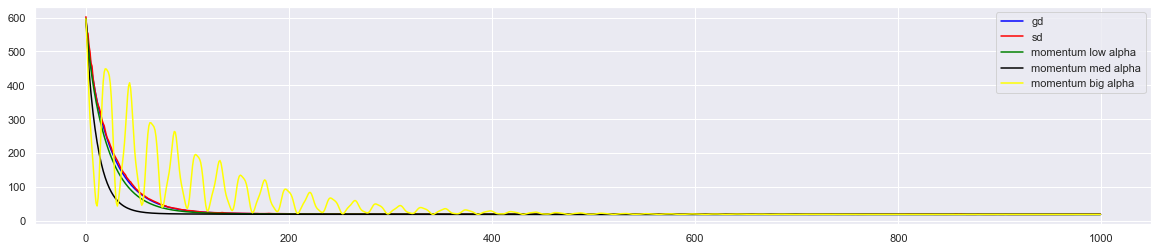

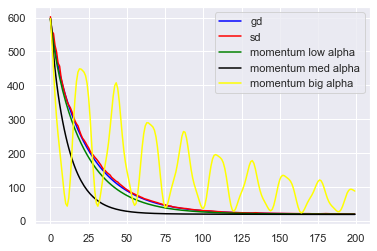

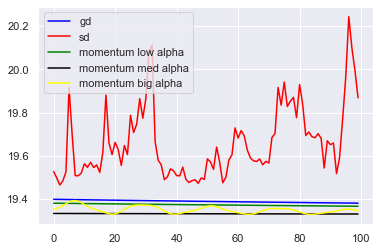

In [52]:
plt.figure(figsize=(20,4))
#All points
plt.plot(GD.loss_history,label='gd', color = 'blue')
plt.plot(SD.loss_history,label='sd', color = 'red')
plt.plot(MomentumLowA.loss_history,label='momentum low alpha', color = 'green')
plt.plot(Momentum.loss_history,label='momentum med alpha', color = 'black')
plt.plot(MomentumBigA.loss_history,label='momentum big alpha', color = 'yellow')
plt.legend()
plt.show()

#first 200 points
plt.plot(GD.loss_history[:200],label='gd', color = 'blue')
plt.plot(SD.loss_history[:200],label='sd', color = 'red')
plt.plot(MomentumLowA.loss_history[:200],label='momentum low alpha', color = 'green')
plt.plot(Momentum.loss_history[:200],label='momentum med alpha', color = 'black')
plt.plot(MomentumBigA.loss_history[:200],label='momentum big alpha', color = 'yellow')
plt.legend()
plt.show()

#last 100 points
plt.plot(GD.loss_history[900:],label='gd', color = 'blue')
plt.plot(SD.loss_history[900:],label='sd', color = 'red')
plt.plot(MomentumLowA.loss_history[900:],label='momentum low alpha', color = 'green')
plt.plot(Momentum.loss_history[900:],label='momentum med alpha', color = 'black')
plt.plot(MomentumBigA.loss_history[900:],label='momentum big alpha', color = 'yellow')
plt.legend()
plt.show()

As we can see, ordinary gradient descent is almost the same as stochastic descent. In the approximation to 1000, we have approximately the same loss function (but for the stochastic, the loss function is still greater)
Momentum behaves differently with different $ \alpha $. That is, if our $ \alpha $ is about 0.5, then the model performs better at the initial iterations, but when tending to infinity, the difference with the usual gradient descent is practically invisible. If $ \alpha $ is close to 0 (eg 0.1), then this method is almost no different from the usual gradient descent. If $ \alpha $ is close to 1 (for example 0.99), then the loss function will behave very strangely, deviating very strongly in both directions. When striving to infinity, the deviations will not be very large, but still there will be (the function is very similar to a dying pendulum)

Как мы видим, обычный градиентный спуск почти не отличается от стахастического. Мы имеем в приближении к 1000 примерно одинаковую функцию потерь (но у стахостического всё равно функция потери больше)
Momentum ведет себя по-разному с разными $\alpha$. То есть если у нас $\alpha$ находится около 0.5, то модель показывает себя лучше на начальных итерациях, но при стремлении к бесконечности разница с обычным градиентным спуском практически не видна. Если $\alpha$ близко к 0 (напримр 0.1), то тогда этот метод почти ничем не отличается от обычного градиентного спуска. Если же $\alpha$ близко к 1 (например 0.99), то тогда функция потерь будет вести себя очень странно, отклоняясь очень сильно в обе стороны. При устремлении в бесконечность отклонения будут не особо большие, но всё же будут (функция очень похожа на затихающий маятник) 